In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

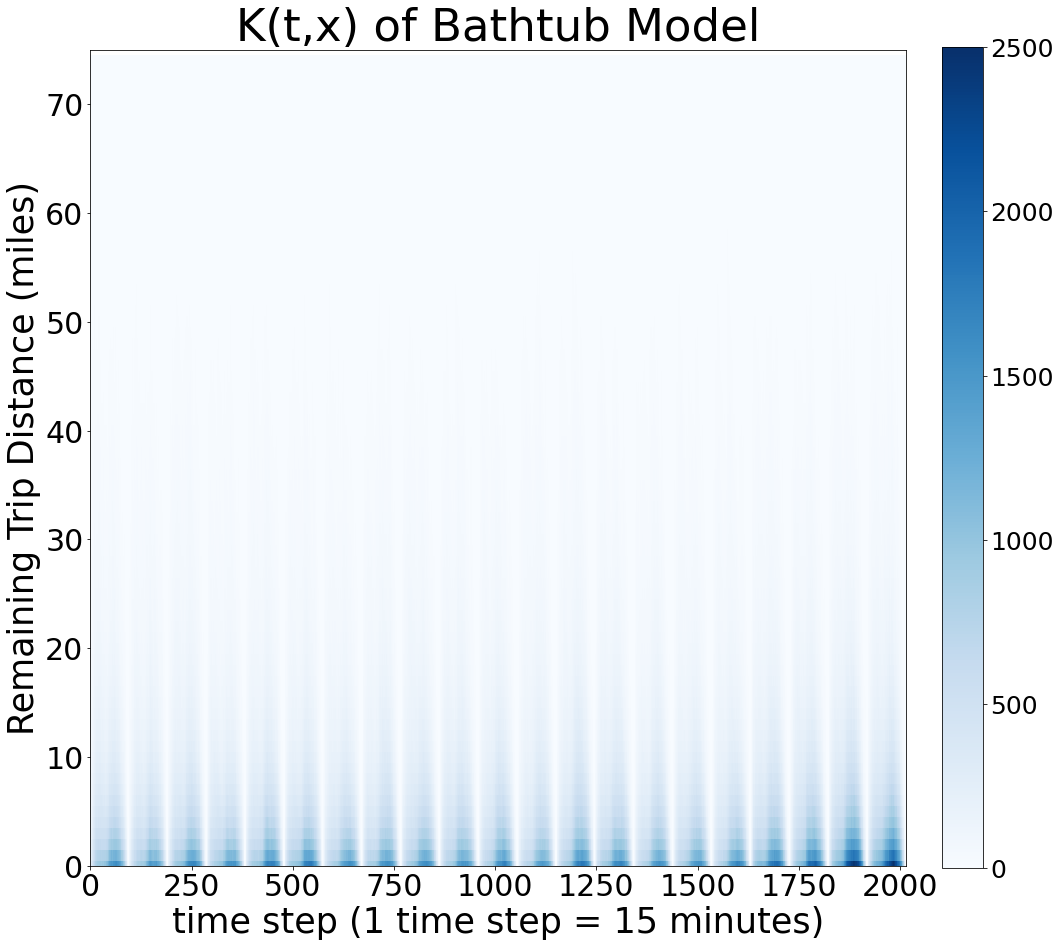

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.01010503188258868 0.017335006870812374 0.0028750568943649865 0.9853852871172675
0.0083623679376982167 0.015049653333510318 0.0016750825418861155 0.9283204152208527
0.0073854832669212516 0.014068266742249135 0.00070269979159336756 0.8951795281318748
0.0071467657327910841 0.013643160234252553 0.0006503712313296146 0.8816781161635098
0.0058775380552743275 0.011127940973007565 0.00062713513754109008 0.8001209225630712
0.0052800448496703213 0.010085874504706625 0.00047421519463401794 0.7668493660892357
0.00515299696146995 0.0099785482224187642 0.000327445700521135 0.7652934795625271
0.0051504852426227125 0.0099859561121143775 0.00031501437313104729 0.7657178612191268
0.0051498135939967663 0.0099870375936255088 0.00031258959436802349 0.7657635166528526
0.0051481894788430712 0.0099868765494901673 0.00030950240819597471 0.7657520536241397
0.0051439457185513855 0.0099831591311348722 0.00030473230596789945 0.7656025295023505
0.005133520472252108 0.0099690808066549043 0.00029796013784931107 0.7

0.0032304042292460827 0.0055306524752640231 0.00093015598322814257 0.575705420405214
0.0032301109815053839 0.0055282702196482987 0.00093195174336246889 0.5755611307757824
0.0032300388807232593 0.00552885660664806 0.0009312211547984581 0.5755735259279169
0.0032300266149134791 0.0055297083098350122 0.00093034491999194563 0.5756124284619055
0.0032300136770195549 0.0055303768237874367 0.000929650530251673 0.5756441868010175
0.0032299772588723617 0.0055315767290550818 0.00092837778868964146 0.5757027139276882
0.0032298899408443609 0.0055329718679756291 0.00092680801371309283 0.5757719463669054
0.0032296699824167644 0.0055351099116171852 0.00092423005321634307 0.575880311571743
0.0032291372920744744 0.00553608156748748 0.00092219301666146883 0.5759262339807254
0.0032280595794599806 0.0055415319626045323 0.00091458719631542867 0.5761801993576108
0.0032264847357893465 0.00555019163231351 0.00090277783926518318 0.5765975211016033
0.0032256167945097676 0.0055409911569451725 0.0009102424320743630

0.0032076174147606692 0.0054952054252094887 0.00092002940431185 0.5735277559263335
0.0032075751897271019 0.005492692925492473 0.00092245745396173074 0.5734008293001384
0.00320754980720854 0.00549121894292257 0.00092388067149451079 0.5733065076841888
0.0032074963832065383 0.0054904971745865063 0.00092449559182657083 0.5732624326576653
0.0032074179359124259 0.0054896752723457868 0.00092516059947906509 0.5732163062760316
0.0032071838256097192 0.0054891462013708326 0.00092522144984860568 0.5731789215311047
0.0032068808242159555 0.005486593199715872 0.000927168448716039 0.5730488001272195
0.0032067449901481324 0.0054757822743605328 0.00093770770593573193 0.5725071748276945
0.0032063482876102467 0.0054824841136276361 0.00093021246159285728 0.5728360214300057
0.003206213450239978 0.0054840098299469113 0.00092841707053304442 0.5729092206785139
0.0032059944841139384 0.00548283720174006 0.00092915176648781627 0.5728287898631581
0.00320570344959173 0.0054782582886866715 0.00093314861049678861 0.5

0.0031738450128440724 0.0054373915986599131 0.00091029842702823171 0.5700038686098752
0.0031737943897379864 0.0054364862720241991 0.00091110250745177342 0.5699576653047834
0.0031737723375187587 0.0054357100931157034 0.00091183458192181362 0.5699191562415193
0.0031737418308496173 0.0054333819164805513 0.00091410174521868283 0.5697968186284318
0.0031737176929475136 0.0054339454329191475 0.00091348995297587982 0.5698270677491152
0.0031737013696763821 0.0054338467097231578 0.00091355602962960632 0.5698164429935791
0.0031736766988667707 0.0054331173610379611 0.00091423603669558 0.5697695516453342
0.003173653175490856 0.0054345620149885022 0.00091274433599320976 0.5698363252765014
0.0031736197496866955 0.0054356506505735215 0.00091158884879986987 0.5698844774582092
0.0031735839336342994 0.0054377699518381875 0.000909397915430411 0.5699923944825246
0.0031735323024895622 0.0054388683613761256 0.00090819624360299921 0.5700493958488444
0.0031734890249563749 0.0054390599192072281 0.00090791813070

0.0031645312721535934 0.00545261281943054 0.00087644972487664673 0.5706081011342103
0.0031640610179243197 0.0054491215979939533 0.00087900043785468578 0.5704315807803303
0.0031636055642774211 0.00544947515704501 0.000877735971509832 0.5704129893443303
0.0031633206918503329 0.0054314905576358062 0.00089515082606485979 0.5694999933246252
0.0031630298075281732 0.0054337429370828645 0.0008923166779734817 0.5695880857846333
0.0031627373691572179 0.005439053406150648 0.0008864213321637882 0.5698725015061964
0.003162533694191554 0.0054350028099298007 0.00089006457845330759 0.5696703028233225
0.003162455792736254 0.0054358178605233808 0.00088909372494912751 0.5697098552505142
0.0031623235247863367 0.0054353719166821794 0.00088927513289049421 0.5697212146595672
0.0031622217797276277 0.0054319796537887132 0.00089246390566654254 0.5695253493501627
0.0031621615390286044 0.0054361934168566332 0.00088812966120057572 0.5697604133765718
0.0031620848991472136 0.00543401291291825 0.00089015688537617723 

0.0031604711067402987 0.005443531003187921 0.00087741121029267675 0.5700682409896359
0.0031604687687890576 0.0054434602952715475 0.00087747724230656759 0.5700653279827034
0.0031604671928955321 0.0054428471510483585 0.00087808723474270579 0.5700329116558188
0.0031604663339255918 0.0054431073107073062 0.00087782535714387756 0.5700464506482709
0.0031604655349931933 0.0054430409620120253 0.00087789010797436121 0.5700430211782449
0.0031604652538717794 0.0054433312073335705 0.000877599300409988 0.5700582494404944
0.0031604651639217168 0.0054432589060265223 0.00087767142181691138 0.5700549312707492
0.00316046509467383 0.0054432526891890392 0.00087767750015862046 0.5700546779703645
0.0031604648979381453 0.0054432067346622546 0.00087772306121403629 0.5700526000498288
0.0031604645611463906 0.0054431386544114444 0.00087779046788133668 0.570049442938727
0.0031604637126665495 0.0054430099392718274 0.00087791748606127161 0.5700434017045299
0.0031604619054689475 0.00544283658228722 0.0008780872286506

0.0031575893117371991 0.0054288919544133894 0.0008862866690610093 0.5692747837166489
0.0031575765625773437 0.005428991056070925 0.00088616206908376282 0.5692774118397002
0.0031575558840917029 0.0054286028149848351 0.00088650895319857112 0.5692531042511038
0.0031575345860732238 0.0054265716150761747 0.00088849755707027329 0.5691503641833426
0.0031575077079378832 0.0054250577644337963 0.00088995765144197017 0.5690661500352392
0.0031574693277466614 0.0054231982518221653 0.0008917404036711574 0.5689771421415514
0.0031574053133620866 0.0054217007130838366 0.00089310991364033668 0.5688944222380234
0.0031573175722803318 0.00542384792738515 0.00089078721717551323 0.5690093753114684
0.0031571804728604677 0.0054204969953744013 0.00089386395034653427 0.5688575927847329
0.0031571014573384681 0.0054260291097887126 0.000888173804888224 0.5691342409398285
0.0031570155890502062 0.0054275834545829812 0.00088644772351743071 0.5692207818152397
0.0031569557801205709 0.00543020662275041 0.00088370493749073

0.0031548768798999112 0.0054230078464700109 0.00088674591332981161 0.5689886753688517
0.0031548740735853182 0.0054233262396451223 0.00088642190752551391 0.5690025854904073
0.0031548679068069793 0.0054240530085470961 0.00088568280506686272 0.5690360855725551
0.0031548583230345583 0.0054248348007390878 0.00088488184533002865 0.5690730432869379
0.0031548437427930858 0.0054256728737446993 0.000884014611841472 0.569115029871269
0.0031548250303637814 0.00542447141444206 0.00088517864628550322 0.5690528356340291
0.0031548174181883818 0.0054255326632576574 0.00088410217311910607 0.5691113656355874
0.0031547951392456859 0.0054222838433467258 0.000887306435144646 0.5689486552877607
0.0031547871500051295 0.0054234397241399038 0.00088613457587035532 0.5690092966430852
0.0031547805426182622 0.0054207404622418779 0.00088882062299464667 0.5688657629901986
0.0031547657234890151 0.0054227794259014235 0.0008867520210766067 0.5689760990097603
0.003154756805747309 0.0054224863464820512 0.00088702726501256

0.0031543631410312057 0.005421860037891444 0.00088686624417096723 0.5689219130458749
0.0031543582615465833 0.0054228247687818955 0.00088589175431127076 0.5689717905893885
0.0031543524030885053 0.0054220794513441086 0.00088662535483290247 0.5689316043492848
0.00315434764094501 0.005422013423269709 0.00088668185862031054 0.5689285969072676
0.0031543420357131929 0.0054211621948292033 0.00088752187659718216 0.5688834429181207
0.0031543389348673767 0.0054222729371566063 0.00088640493257814658 0.5689430480305242
0.00315433446053609 0.0054235463917229028 0.000885122529349277 0.5690135203416632
0.0031543270965010994 0.0054213379613152462 0.00088731623168695226 0.568897478377771
0.0031543202277636577 0.005421609169464321 0.00088703128606299473 0.5689129607883313
0.0031543148728818745 0.0054234198431326623 0.00088520990263108649 0.5690044025878528
0.0031543098260529969 0.0054190388086607089 0.00088958084344528524 0.5687664946913319
0.0031543062190963122 0.0054200107335550937 0.000888601704637530

0.0031417214244115355 0.0054071119255831119 0.0008763309232399588 0.5680625599192995
0.0031414575861938338 0.0053949876210489462 0.00088792755133872158 0.5673942594677986
0.0031413297755190544 0.0053916322042887495 0.00089102734674935944 0.5672010570220123
0.0031411490960177638 0.005397186654806721 0.00088511153722880685 0.5674844819399733
0.0031409926930855213 0.0053998066962538185 0.00088217868991722378 0.5676242213179004
0.0031407620755971224 0.0053963269180231357 0.000885197233171109 0.5674249622192744
0.0031404212425731833 0.0054008457797872266 0.00087999670535914031 0.5676644939633291
0.0031400816128090729 0.00539750379875867 0.000882659426859476 0.5674612621939186
0.003139919641380605 0.005403693466354182 0.00087614581640702818 0.567819155871059
0.0031398547561502219 0.0053836454776021864 0.00089606403469825742 0.566763790916031
0.0031394587161361013 0.00539434030234254 0.00088457712992966262 0.567305139057514
0.0031393099743110423 0.0053957773671106978 0.00088284258151138668 0.

0.0031306614654459126 0.0053851229031036934 0.00087620002778813154 0.5670611519669057
0.0031305924989646194 0.0053839345922959006 0.00087725040563333811 0.5669538480610286
0.0031305203298724834 0.0053855047508568465 0.00087553590888812 0.5670390764313559
0.0031304547911134516 0.0053867715489289624 0.0008741380332979409 0.5671150902669961
0.0031303787345895043 0.0053881018581832018 0.000872655610995807 0.5671866977958832
0.00313033152549653 0.0053870641622836167 0.00087359888870944355 0.5671379195002038
0.0031302963381310035 0.0053923902329657087 0.00086820244329629875 0.5673998547361092
0.0031302364063643603 0.0053854480261039074 0.00087502478662481364 0.5670216734490415
0.0031302170417432692 0.0053863017565542858 0.00087413232693225255 0.567077852520337
0.0031301845089656555 0.0053870733050604179 0.0008732957128708928 0.5671153453276347
0.0031301571201075842 0.0053876462471312194 0.00087266799308394942 0.5671440284307377
0.0031300716759486095 0.00538776162828431 0.00087238172361290959

0.0031281109152343539 0.0053862707146922909 0.00086995111577641731 0.5669227101775591
0.0031280803142887297 0.0053830170187173796 0.00087314360986007992 0.566744032528413
0.003128069632441533 0.0053834404146601315 0.00087269885022293458 0.5667674944173677
0.0031280560081650539 0.0053860913187625649 0.000870020697567543 0.5669048323672135
0.0031280473509010271 0.0053853905975275 0.00087070410427455376 0.5668648101790118
0.0031280347389753844 0.0053850424987714777 0.00087102697917929071 0.566841786402223
0.0031280044835116441 0.0053874833184979617 0.00086852564852532663 0.5669597945960577
0.0031279640919622126 0.0053829726355430979 0.00087295554838132724 0.5667055040155894
0.0031279333188869076 0.0053841788422476066 0.0008716877955262085 0.5667688903186022
0.0031278853900869995 0.0053802257867089347 0.00087554499346506392 0.5665777430961373
0.003127874455591977 0.0053811189733694647 0.00087462993781448962 0.5666292723086903
0.0031278458864660557 0.0053793864415788159 0.000876305331353295

0.0031198831988537078 0.0053448984787860376 0.00089486791892137794 0.5646875320876362
0.0031198333975006936 0.0053453126747973669 0.00089435412020402066 0.5646979179747271
0.0031197525956644075 0.0053435234205513344 0.00089598177077748081 0.5645921926134599
0.0031195756714365828 0.0053427812675504744 0.00089637007532269086 0.5645199966457469
0.0031193375567998248 0.0053369038333645228 0.00090177128023512709 0.5641904252222719
0.00311922196672987 0.0053393097486611734 0.00089913418479856664 0.5643017060993349
0.0031188869662137132 0.0053472894190038237 0.00089048451342360288 0.5647265749540582
0.0031186104708183738 0.0053411783418826492 0.0008960425997540986 0.5643670155441977
0.0031183464687843262 0.0053303322765105993 0.000906360661058053 0.5638159783686137
0.003118037226462732 0.0053171248830697982 0.00091894956985566544 0.5630957468190987
0.0031177321008565295 0.0053176082167365035 0.00091785598497655569 0.5630868912233854
0.0031174285927113251 0.0053196997939416206 0.00091515739148

0.0030966496732299834 0.0052844718601295047 0.000908827486330462 0.5611429002191328
0.0030965782834686323 0.0052806357067436147 0.00091252086019364981 0.5609377754731535
0.003096482731846754 0.0052825870616791176 0.00091037840201439073 0.5610210705319697
0.0030964509394415685 0.0052869649963914146 0.000905936882491722 0.5612674905578167
0.0030963964964813733 0.0052826357303303682 0.00091015726263237839 0.56102537823917
0.0030963303155972623 0.0052820422555664168 0.0009106183756281078 0.5609925903661155
0.003096262137612299 0.0052855957298965951 0.00090692854532800247 0.5611919820607746
0.0030961801878233936 0.0052840317408106375 0.00090832863483614949 0.5611068129618546
0.0030960841623511814 0.0052850041234374628 0.00090716420126489973 0.5611486717765581
0.0030960059237975551 0.0052861727892657756 0.000905839058329335 0.5612158766513764
0.0030958816206873309 0.0052798099545820973 0.00091195328679256492 0.5608676571540493
0.0030958212460984397 0.0052826939204716631 0.0009089485717252161

0.0030687783395376856 0.0052597848401167357 0.00087777183895863527 0.5597949709831594
0.0030687763727774166 0.0052600942202464694 0.00087745852530836366 0.5598132298641294
0.0030687757404844291 0.0052601425939873721 0.00087740888698148575 0.5598160114134001
0.00306877486692722 0.0052603285304740873 0.00087722120338035257 0.5598256684702944
0.0030687742473576589 0.0052603926084771584 0.00087715588623815937 0.5598286958413042
0.0030687737293084829 0.005260439196101154 0.00087710826251581142 0.5598308925277868
0.003068772894966976 0.0052604595559418077 0.00087708623399214457 0.5598317579754787
0.0030687708246284937 0.005260486585154862 0.00087705506410212526 0.5598330451491191
0.0030687656341423005 0.0052605138349781609 0.00087701743330644043 0.5598345129726057
0.0030687519141383971 0.0052605465048831393 0.00087695732339365489 0.5598362977065311
0.0030687160975198255 0.0052605938400732627 0.00087683835496638832 0.5598385473661804
0.0030686234490771682 0.00526069848574176 0.000876548412412

0.0030661601001057154 0.005250030982001495 0.0008822892182099362 0.5592455991142651
0.003066146928132423 0.0052503113892675 0.00088198246699734619 0.5592593262414689
0.003066139288012428 0.0052505334254853977 0.00088174515053945782 0.5592714199478791
0.003066127940054183 0.0052508545697407556 0.00088140131036761071 0.5592887362818965
0.0030661250954534332 0.0052499761385293251 0.00088227405237754116 0.5592458584737817
0.0030661169908432887 0.0052502235914860338 0.00088201039020054366 0.559254295167607
0.0030661027028024506 0.0052502970668397769 0.00088190833876512407 0.5592567251655726
0.0030660966781169141 0.00525045998901268 0.00088173336722114834 0.559264956174223
0.0030660750356188483 0.0052500481574280361 0.00088210191380966036 0.5592397699768573
0.0030660638370625963 0.0052503012843913861 0.00088182638973380648 0.5592532163618559
0.0030660545131824292 0.0052506165297387646 0.00088149249662609344 0.5592700029601129
0.0030660389192682883 0.0052510452420258405 0.00088103259651073622

0.0030627123965965429 0.005239188090194212 0.00088623670299887416 0.5585797480484912
0.0030627121050741451 0.0052392194192255291 0.0008862047909227608 0.5585814515826286
0.0030627118070548449 0.0052392351324896886 0.00088618848162000169 0.5585822115412393
0.0030627113558714825 0.0052392533959387229 0.000886169315804242 0.5585833396979368
0.0030627106853022114 0.0052393039140701961 0.0008861174565342264 0.5585860085577465
0.003062709117491826 0.0052393112554630014 0.00088610697952065047 0.5585867629225478
0.0030627054952072461 0.0052395820267688124 0.00088582896364568 0.5586012845859339
0.0030626968916175838 0.0052396685284814472 0.00088572525475372058 0.5586060429422762
0.0030626790037561187 0.0052401057176338266 0.00088525228987841045 0.5586277858919931
0.0030626636482111651 0.0052403343887421783 0.00088499290768015155 0.5586426650110922
0.003062627204641781 0.0052403906354768874 0.00088486377380667461 0.5586469665360125
0.0030625886213706734 0.0052402522628872588 0.000884924979854088

0.0030622202837843528 0.0052357037382467237 0.00088873682932198207 0.5584000826088222
0.0030622201286396732 0.0052356281306898478 0.00088881212658949822 0.5583961659002548
0.0030622200879859463 0.0052356057569767816 0.00088883441899511066 0.5583950455335438
0.0030622199531927566 0.0052355652290598216 0.00088887467732569185 0.5583928928317017
0.0030622198806085463 0.0052355298225863645 0.000888909938630728 0.558390873566401
0.0030622197566108809 0.0052354625905238848 0.00088897692269787707 0.5583867861822195
0.0030622195849815416 0.0052354029673849466 0.00088903620257813683 0.5583827729641886
0.0030622192729086012 0.0052352674945090032 0.00088917105130819924 0.5583742249818515
0.0030622188157272516 0.0052351038291809718 0.00088933380227353121 0.5583642990211534
0.0030622176524887704 0.0052348384398732987 0.00088959686510424181 0.558348307931225
0.0030622163924750633 0.0052346617632521254 0.000889771021698001 0.5583383490977842
0.0030622145704798619 0.00523439275669023 0.0008900363842694

0.0030612879182523008 0.00522840482856333 0.00089417100794127137 0.5580295417425939
0.0030612479256229524 0.0052279062458331768 0.00089458960541272776 0.5579974893730474
0.0030612251795577978 0.0052276745611901359 0.00089477579792546 0.5579856741354159
0.003061168973419689 0.0052275358415128223 0.00089480210532655606 0.5579617572691471
0.003061109009678493 0.0052275337151579237 0.0008946843041990624 0.5579603721426192
0.0030609254661651004 0.0052285613870681385 0.0008932895452620623 0.55800097290001
0.003060889304632451 0.0052289093041300878 0.00089286930513481414 0.5580429460069817
0.0030608629417123827 0.0052287594016020844 0.00089296648182268063 0.5580421233170938
0.00306083554239995 0.005228193604648157 0.00089347748015174329 0.5580271629120493
0.0030607962141832555 0.0052278612080078049 0.00089373122035870615 0.5580085366766283
0.003060760461895995 0.0052284754015038465 0.0008930455222881438 0.5580278477442472
0.0030607407156278683 0.0052262637502209835 0.00089521768103475324 0.55

0.0030606433719085218 0.0052256023164326615 0.000895684427384382 0.5578932843051914
0.0030606428057048866 0.0052257075494078174 0.0008955780620019555 0.557898699412327
0.0030606426879359223 0.0052257185157246712 0.00089556686014717363 0.5578994422941232
0.0030606425445661831 0.0052257355803438689 0.00089554950878849749 0.5578999235714067
0.0030606424814306125 0.00522575200719529 0.0008955329556659357 0.5579002462033213
0.0030606424582449859 0.0052257469982682344 0.00089553791822173732 0.5578996237679081
0.0030606424379221618 0.0052257210998615782 0.00089556377598274577 0.5578980588407072
0.0030606424047238084 0.0052256932843790958 0.000895591525068521 0.5578958904270734
0.003060642339842024 0.0052256696846430814 0.000895614995040967 0.5578947614080201
0.0030606420141821087 0.0052254515734932337 0.00089583245487098392 0.5578843800601962
0.003060641841477594 0.005225363468200417 0.00089592021475477118 0.5578795832981353
0.0030606416253110922 0.0052253808645941341 0.00089590238602804987 0

0.0030606255264174665 0.0052255857127949581 0.00089566534003997461 0.5578913055377035
0.0030606254544772163 0.0052256089007529189 0.00089564200820151357 0.5578925992568292
0.0030606254172537367 0.005225632377198447 0.00089561845730902641 0.5578938702251812
0.0030606253850495287 0.0052256828720053513 0.00089556789809370585 0.5578970376920006
0.0030606253619234148 0.0052257912447430718 0.00089545947910375811 0.5579023805807386
0.0030606253378064469 0.0052257422924446035 0.00089550838316829033 0.5578998420305323
0.0030606253188333633 0.0052257211024087577 0.00089552953525796918 0.557898734551123
0.0030606252747390652 0.0052256929215544748 0.00089555762792365573 0.5578971924031028
0.0030606251992749563 0.0052256706948537223 0.00089557970369619048 0.5578959170400134
0.00306062505414259 0.0052256416396382326 0.00089560846864694742 0.5578941088801609
0.0030606249223524336 0.0052256321024946378 0.00089561774221022983 0.5578936986123175
0.0030606246342607438 0.0052255806232647693 0.000895668645

0.0030605379564561065 0.00522416634784133 0.0008969095650708833 0.5578234497837711
0.0030605356153028352 0.005224355202171539 0.00089671602843413188 0.5578309456113065
0.0030605347633184932 0.0052248841244567279 0.00089618540218025858 0.5578555772333759
0.0030605341168583912 0.00522487880127678 0.00089618943244000279 0.5578548834370419
0.003060533638548326 0.0052246964707520866 0.00089637080634456551 0.5578452378980255
0.0030605334674682814 0.00522474801611979 0.00089631891881677278 0.5578475949104579
0.0030605333127810587 0.0052248262525723035 0.0008962403729898137 0.5578510193249623
0.0030605332278576475 0.005224856987288206 0.00089620946842708913 0.5578525023865911
0.003060533109866492 0.0052249089365474857 0.00089615728318549867 0.5578549682389438
0.0030605330788495665 0.0052248658802617389 0.00089620027743739423 0.55785337529265
0.0030605330178570989 0.0052248734890843682 0.00089619254662982981 0.5578538061312527
0.0030605328907160351 0.0052248626766330554 0.0008962031047990151 0.

0.0030582159151409352 0.0052266888527703918 0.00088974297751147867 0.5580171773945328
0.0030581890966633195 0.0052280752214806207 0.00088830297184601793 0.5580952003702085
0.0030581701515819534 0.0052279704140269717 0.00088836988913693548 0.5580836398703676
0.0030581442302228443 0.0052280654333715371 0.00088822302707415146 0.5580891960953961
0.0030580998222896139 0.0052288949566935876 0.00088730468788563994 0.5581350253870572
0.0030580047560297896 0.0052297380085139077 0.00088627150354567152 0.55818056183311
0.0030579389964661076 0.0052293666696255226 0.00088651132330669238 0.5581654539165029
0.0030577846015306543 0.005228125910471117 0.00088744329259019125 0.5581082920387838
0.0030576929247407014 0.0052268356040804957 0.0008885502454009076 0.5580635045446186
0.0030575529444122 0.0052276991121884674 0.00088740677663593285 0.558099346648831
0.0030575139262371885 0.0052279293774548548 0.00088709847501952242 0.558115319475475
0.0030574916780342727 0.0052281966028966077 0.00088678675317193

0.0030518058123190253 0.00521050207697055 0.00089310954766750065 0.5572480413959798
0.003051777326367979 0.0052093527544748632 0.0008942018982610947 0.5571944035151242
0.0030517397564817951 0.005207933094829773 0.00089554641813381706 0.5571116967261256
0.0030516981719302316 0.0052091831458055821 0.0008942131980548808 0.5571828744632801
0.0030516673711431372 0.00521143284049075 0.00089190190179552406 0.5573063332382316
0.0030516434154749406 0.0052113822531148109 0.00089190457783507059 0.557299445241876
0.003051621565701235 0.0052106712665143549 0.00089257186488811522 0.5572646702835158
0.0030515918794074394 0.0052112304087297756 0.0008919533500851035 0.5572981285507446
0.0030515646540114323 0.0052096590272156231 0.000893470280807242 0.5572064509517579
0.0030515513352855524 0.0052092702659957916 0.00089383240457531271 0.5571868090958777
0.0030515189786454898 0.0052100176188029012 0.00089302033848807786 0.5572316761443985
0.003051490696861202 0.0052100052908050885 0.00089297610291731516 0

0.0030503898077055254 0.0052024929076987239 0.00089828670771232709 0.5568523875031443
0.003050386703161843 0.0052022449703109193 0.00089852843601276647 0.5568401770354461
0.0030503800594569503 0.0052019507710175895 0.00089880934789631091 0.5568273109835092
0.0030503753939050689 0.0052019909439701729 0.00089875984383996454 0.5568362537334726
0.003050364219868307 0.0052017008578837459 0.00089902758185286824 0.5568180016501704
0.0030503569236294725 0.0052013449284214622 0.00089936891883748277 0.5567993934111537
0.00305034525454117 0.0052011022692252688 0.0008995882398570717 0.5567859858242834
0.0030503324225500876 0.0052012949945821263 0.00089936985051804912 0.5567901282002145
0.0030503269878520488 0.0052014328059050178 0.0008992211697990796 0.5567996548889911
0.0030503197685613995 0.0052016660547259154 0.00089897348239688347 0.5568175220340666
0.0030503143354473758 0.0052016105834389748 0.00089901808745577669 0.5568148197187835
0.0030503066827995392 0.0052010255175180846 0.00089958784808

0.0030495788928433746 0.0052005895268479943 0.00089856825883875466 0.5567808816702761
0.0030495776170884237 0.0052002103303307994 0.00089894490384604764 0.5567605918615973
0.003049576659737803 0.0052006049671962677 0.00089854835227933872 0.5567822748989771
0.0030495759476196608 0.0052007408489142815 0.00089841104632504038 0.5567885905706289
0.0030495752683556048 0.0052006524266052486 0.00089849811010596131 0.556784552522746
0.0030495749531816913 0.0052005077406216075 0.000898642165741775 0.5567755089186939
0.0030495746188630426 0.0052002687166174946 0.000898880521108591 0.5567640511248421
0.0030495741209049195 0.0052004887118020961 0.000898659530007743 0.5567751692910979
0.0030495737018863857 0.0052006080080711893 0.00089853939570158235 0.5567812212938981
0.0030495729221736378 0.0052007568895205058 0.0008983889548267697 0.5567893076027225
0.0030495722797902036 0.0052010202121274352 0.0008981243474529717 0.5567999430225996
0.0030495698421662068 0.0052010358751250606 0.000898103809207352

0.0030486432811044684 0.005200867757139062 0.00089641880506987476 0.5568255855042349
0.003048640401463693 0.0052008686281887267 0.00089641217473865938 0.5568250826838703
0.0030486384471758387 0.00520136761934274 0.00089590927500893692 0.5568534136232381
0.0030486370887256283 0.0052011844586562763 0.00089608971879498033 0.5568430295672508
0.0030486367084022951 0.0052009024876537415 0.00089637092915084877 0.5568276085588407
0.0030486356784712484 0.0052008349770789842 0.00089643637986351284 0.5568243965745969
0.003048634426604988 0.0052012101446492149 0.00089605870856076131 0.5568450183846967
0.003048632658053278 0.0052012659565720811 0.00089599935953447508 0.5568495551750449
0.0030486313434034706 0.0052011324914000992 0.000896130195406842 0.5568440794294612
0.0030486307285219057 0.00520096245464308 0.00089629900240073091 0.5568353166566667
0.0030486293934279597 0.0052008236408299085 0.00089643514602601117 0.5568287067582514
0.0030486270687060434 0.0052006437231517074 0.000896610414260379

0.0030482788697472171 0.00520011691746461 0.00089644082202982429 0.5567989696887575
0.0030482788591283576 0.0052000919831925565 0.00089646573506415878 0.5567979102308793
0.0030482788566150464 0.0052000804655073039 0.00089647724772278924 0.5567973525437347
0.0030482788564314264 0.0052000815504228562 0.00089647616243999613 0.5567974149241574
0.0030482788561917691 0.0052000825049181229 0.00089647520746541527 0.5567974468339191
0.0030482788561314064 0.0052000828796783935 0.00089647483258441935 0.5567974550968257
0.0030482788560958094 0.0052000830672796518 0.00089647464491196722 0.5567974628127735
0.003048278856011684 0.0052000819183653513 0.00089647579365801646 0.5567973840216833
0.0030482788558724352 0.0052000848190467235 0.00089647289269814733 0.5567975420740474
0.0030482788548918264 0.0052000904597633 0.00089646725002035335 0.5567978268917897
0.0030482788524241883 0.0052001004016188129 0.00089645730322956356 0.5567983360788318
0.0030482788447557738 0.0052001208405176389 0.00089643684899

0.0030482729344805098 0.0052000351526720048 0.000896510716289015 0.5567959015218016
0.0030482728662038256 0.0051999844272007491 0.000896561305206902 0.5567928386922868
0.0030482727348357243 0.0051998874293992517 0.00089665804027219676 0.5567876949224098
0.0030482726509100844 0.0051998580810508352 0.00089668722076933387 0.5567861270213053
0.0030482725148652835 0.00519977953503118 0.00089676549469938768 0.5567812584458662
0.0030482724677239254 0.0051998182657737322 0.00089672666967411871 0.5567834593135595
0.0030482723299943486 0.00520002677302882 0.0008965178869598775 0.5567943523765465
0.003048272215474893 0.0052001538723540847 0.00089639055859570143 0.5568012570785846
0.0030482719920910868 0.0052003214559932847 0.00089622252818888847 0.5568106795482562
0.0030482719153337176 0.0052003568104861146 0.0008961870201813207 0.556812531375
0.0030482717430117359 0.0052003150577938015 0.00089622842822966993 0.556810577528782
0.0030482715494266686 0.0052002227067682186 0.00089632039208511886 0.5

0.0030482264933720023 0.0052000689296890987 0.00089638405705490557 0.5567988912401503
0.0030482260395707341 0.0051998660730402735 0.00089658600610119474 0.5567874137971177
0.0030482254693686289 0.0051998688846516686 0.00089658205408558935 0.5567871953776432
0.0030482246035705733 0.0052000665973414052 0.00089638260979974112 0.5567975712613239
0.0030482237922221751 0.0052002816378651185 0.00089616594657923143 0.5568090236948402
0.0030482231821908918 0.0052005462820978732 0.00089590008228391084 0.556821243095195
0.0030482223075974425 0.0052006754487808043 0.00089576916641408079 0.5568296686564025
0.003048221186893854 0.0052008272148124811 0.00089561515897522686 0.5568362979816773
0.0030482202791006418 0.0052005490737955665 0.00089589148440571737 0.556821538771689
0.0030482189391643124 0.0051999385464291106 0.00089649933189951464 0.5567903711900649
0.0030482172369308757 0.0051997195576348638 0.00089671491622688772 0.5567768326387839
0.0030482145852238239 0.0052002533766743082 0.00089617579

0.0030477511908417682 0.0052015630310758669 0.00089393935060766991 0.5568792988314741
0.0030477485139773757 0.0052003365508575721 0.00089516047709717935 0.5568195854904331
0.003047745657659349 0.0052005515151967831 0.00089493980012191466 0.5568316119421782
0.0030477433157735019 0.00520090229676473 0.00089458433478227376 0.5568510774775518
0.0030477355835869294 0.0052009062336284065 0.00089456493354545246 0.5568558706673689
0.0030477300165753863 0.00520084568198471 0.00089461435116606287 0.5568507962903488
0.0030477275240764542 0.0052006368136542835 0.00089481823449862475 0.5568416688943181
0.0030477250777260038 0.0051998090825535487 0.000895641072898459 0.5567981614133176
0.0030477214272576938 0.0051998152678669083 0.00089562758664847911 0.5567934893963434
0.0030477181545889511 0.0051997651907115632 0.00089567111846633875 0.5567894478229464
0.0030477155843704573 0.0052005606813806749 0.00089487048736024 0.5568296458533892
0.0030477141184204358 0.0052004753850445869 0.000894952851796284

0.0030474328369154251 0.0052007559576401048 0.00089410971619074552 0.5568340415207021
0.0030474319842778543 0.00520072805637029 0.00089413591218541846 0.5568318083111495
0.0030474309102451894 0.0052007029246096542 0.00089415889588072435 0.5568304491789021
0.003047430023133109 0.0052002402728266632 0.00089461977343955473 0.5568057229068185
0.0030474290449814031 0.0052004412149688241 0.00089441687499398209 0.5568173543582025
0.0030474276062098212 0.0052006161545917863 0.00089423905782785634 0.5568273714483521
0.003047424860661182 0.0052006490830080795 0.00089420063831428462 0.5568290915141719
0.0030474223913643716 0.0052008366221217937 0.0008940081606069499 0.5568387049993059
0.0030474212878031318 0.0052010156813352328 0.00089382689427103073 0.5568487477783964
0.0030474196928520266 0.0052011358849076714 0.00089370350079638215 0.5568544482044215
0.0030474187385985006 0.00520098591151537 0.00089385156568163064 0.5568457050515226
0.0030474183572340892 0.005200770032543124 0.0008940666819250

0.0030473636220848567 0.0052006448214409638 0.0008940824227287495 0.5568243225018918
0.0030473633965643686 0.005200559036460912 0.00089416775666782493 0.5568196259043378
0.0030473630050788475 0.005200624489955283 0.0008941015202024123 0.5568237267711139
0.0030473627321188309 0.0052007734132316994 0.00089395205100596209 0.5568313933597928
0.0030473624531854814 0.005201076164201293 0.00089364874216967015 0.556847903398662
0.0030473622545651017 0.0052010249519377477 0.00089369955719245588 0.5568446210280567
0.0030473620822961422 0.0052009085004309733 0.00089381566416131119 0.5568378797564134
0.0030473618788461982 0.0052007934818392521 0.00089393027585314461 0.5568316103461064
0.00304736168912546 0.0052007616363215605 0.00089396174192935939 0.5568298770831082
0.0030473614321567927 0.00520082001660557 0.00089390284770801535 0.5568337304228772
0.0030473612904388936 0.0052009162016758469 0.00089380637920194038 0.5568396140173363
0.0030473611153742624 0.0052008566971971969 0.000893865533551327

0.0030473117424730861 0.0052009173726108139 0.00089370611233535822 0.55683437626126
0.0030473115223707955 0.0052009327548458656 0.00089369028989572563 0.5568353535693417
0.0030473110912139318 0.0052009281595897612 0.0008936940228381025 0.5568357683054754
0.0030473108874422947 0.0052009406591256016 0.00089368111575898748 0.5568364723090031
0.0030473107431031967 0.0052009958741464869 0.00089362561205990623 0.5568405353876393
0.0030473106266712215 0.0052010878555618255 0.00089353339778061786 0.5568454377464632
0.003047310397121522 0.0052011460400135942 0.00089347475422945006 0.5568481465621304
0.0030473101676249904 0.0052009429820435464 0.00089367735320643475 0.5568364059720659
0.003047310004974733 0.0052008797574258948 0.00089374025252357125 0.5568327118483004
0.0030473097900663979 0.0052010453181970369 0.00089357426193575928 0.556840775038232
0.003047309643033359 0.0052010823689181869 0.00089353691714853117 0.5568430400052938
0.0030473094710659248 0.0052010252046990118 0.000893593737432

0.0030472843955433046 0.0052010622766085358 0.00089350651447807317 0.5568404095842648
0.003047284251944679 0.0052010678713937863 0.00089350063249557185 0.5568407783161429
0.0030472840674381284 0.0052010877061950166 0.00089348042868124034 0.5568419567920045
0.0030472838694304513 0.0052010628790421969 0.00089350485981870532 0.5568408034808919
0.0030472835752921468 0.0052011405059592215 0.00089342664462507175 0.5568448986442281
0.0030472834559361487 0.0052011789431008551 0.00089338796877144245 0.556846662283884
0.0030472831627050829 0.0052012433676795434 0.00089332295773062213 0.5568490734061667
0.0030472831086667991 0.0052013092261735255 0.00089325699116007279 0.5568525068810722
0.0030472828609874334 0.0052013132498770834 0.000893252472097783 0.5568532511782159
0.0030472827466846751 0.00520126566038841 0.00089329983298094015 0.5568507484527699
0.0030472825876378465 0.0052010799457859131 0.00089348522948977957 0.5568409544851896
0.003047282444296738 0.0052010230364177212 0.000893541852175

0.0030472766261449933 0.0052011755796631375 0.0008933776726268495 0.5568455834588425
0.0030472766241253194 0.00520117476861729 0.00089337847963334911 0.5568455097487375
0.0030472766209114154 0.00520117916122665 0.00089337408059618072 0.5568458208176723
0.0030472766177626945 0.0052011798002924879 0.000893373435232901 0.5568458809357584
0.0030472766104293536 0.0052011762415068285 0.00089337697935187844 0.5568457244523861
0.0030472765970412886 0.0052011767242206896 0.00089337646986188722 0.5568457413989784
0.0030472765921564656 0.005201172402476445 0.00089338078183648611 0.5568455121627901
0.0030472765795207689 0.0052011686880873483 0.000893384470954189 0.5568451816473676
0.0030472765784583513 0.0052011882219949795 0.00089336493492172295 0.5568461568430443
0.003047276571697225 0.0052011914476568647 0.0008933616957375848 0.5568463610539367
0.0030472765688295111 0.0052011889456960473 0.00089336419196297449 0.5568462209517826
0.003047276565815717 0.0052011905872364353 0.00089336254439499824 

0.0030472760906637346 0.0052012025613653772 0.00089334961996209163 0.5568469907017387
0.0030472760854953615 0.0052012005926135333 0.00089335157837718937 0.5568469389796493
0.0030472760796821183 0.0052011860446019055 0.00089336611476233162 0.55684619827072
0.00304727607277795 0.0052011589410040733 0.00089339320455182668 0.5568446954590557
0.0030472760676298694 0.0052011633422032865 0.00089338879305645271 0.5568448067406773
0.00304727606479471 0.0052011679961543357 0.00089338413343508481 0.556845044423997
0.0030472760561432556 0.00520119786270281 0.00089335424958370165 0.5568465873240462
0.0030472760490616651 0.0052012143755355593 0.00089333772258777056 0.5568474406013849
0.0030472760433447915 0.005201211880207661 0.00089334020648192244 0.5568473461076605
0.0030472760327654998 0.0052011939306384654 0.00089335813489253434 0.5568464480055194
0.0030472760309837037 0.0052011829418998207 0.00089336912006758693 0.5568459321869487
0.0030472760214281655 0.00520115734118047 0.00089339470167586112

0.0030472753738740163 0.0052011646768621508 0.00089338607088588183 0.5568449562242009
0.003047275366575489 0.0052011749890068081 0.0008933757441441704 0.5568454053127092
0.0030472753637138541 0.0052011870261685121 0.0008933637012591961 0.5568460029742379
0.003047275358570278 0.0052012003017152791 0.0008933504154252773 0.556846670410964
0.0030472753547341434 0.0052012193281850477 0.00089333138128323949 0.5568476606089717
0.0030472753513725174 0.0052012275305872175 0.00089332317215781677 0.5568481316999022
0.003047275347676499 0.0052012282514701568 0.0008933224438828415 0.556848190194518
0.0030472753398448028 0.0052012269905789416 0.00089332368911066394 0.5568482220563551
0.0030472753362857929 0.005201215575737393 0.00089333509683419288 0.5568475742858183
0.0030472753326350526 0.00520121744468242 0.00089333322058768446 0.556847686089356
0.0030472753265281503 0.005201213469645736 0.0008933371834105642 0.5568475398130035
0.0030472753220308862 0.0052012084513749718 0.00089334219268680031 0.

0.0030472747221529945 0.0052012056540296607 0.00089334379027632854 0.5568469750632409
0.0030472747197144482 0.0052012037829645566 0.00089334565646434 0.5568468794810265
0.0030472747160336733 0.0052012007719899759 0.00089334866007737088 0.5568467008429031
0.0030472747096309785 0.0052011927123469812 0.00089335670691497587 0.5568462563784443
0.0030472747057857549 0.0052011885481647617 0.00089336086340674784 0.5568460751111931
0.0030472747009631044 0.0052011862632605635 0.00089336313866564547 0.5568460458635952
0.0030472746987365512 0.0052011825225524548 0.00089336687492064725 0.5568458881695408
0.0030472746965739964 0.00520118427076997 0.000893365122378023 0.5568459692613783
0.0030472746924356392 0.005201189131666264 0.00089336025320501463 0.5568462033936666
0.003047274687271079 0.0052011986309689036 0.0008933507435732544 0.5568467115626518
0.0030472746844594383 0.005201212400442059 0.00089333696847681741 0.5568472805886139
0.0030472746793633854 0.00520121295662196 0.00089333640210481071 

0.0030472740801354074 0.0052012181746863041 0.0008933299855845107 0.556847841023226
0.0030472740711334559 0.0052012141064882965 0.0008933340357786155 0.5568475653207252
0.0030472740602990283 0.0052011957554682995 0.00089335236512975687 0.5568466873003127
0.0030472740480026812 0.0052011712332945782 0.00089337686271078463 0.5568452829677866
0.0030472740370373927 0.0052011570378348556 0.00089339103623992946 0.5568445596489521
0.0030472740279598115 0.00520116065420311 0.00089338740171651307 0.5568444789739428
0.0030472740166258348 0.0052011564657831891 0.0008933915674684803 0.5568444689468564
0.0030472740083726671 0.0052011652401929625 0.00089338277655237218 0.5568449335051133
0.0030472740010066648 0.0052011670359024048 0.00089338096611092459 0.5568450618157845
0.0030472739919954507 0.0052011647472532648 0.000893383236737637 0.5568449637395225
0.0030472739845210112 0.0052011722170741638 0.00089337575196785882 0.5568454950598049
0.0030472739696938106 0.0052011790469187868 0.0008933688924688

0.0030472733897416327 0.0052011918180303119 0.00089335496145295367 0.5568460730084861
0.0030472733847089822 0.0052011747397530273 0.000893372029664937 0.556845235685957
0.0030472733785686752 0.0052011599349202553 0.000893386822217095 0.5568445204740767
0.003047273367516552 0.0052011439953027561 0.00089340273973034789 0.5568437511649883
0.003047273361823278 0.0052011527927436239 0.00089339393090293235 0.556844357115458
0.0030472733491082368 0.0052011916740514535 0.00089335502416502 0.556846331259213
0.0030472733370080435 0.0052012002538339439 0.000893346420182143 0.5568468627243298
0.0030472733238026671 0.0052012037206518556 0.0008933429269534787 0.5568469618752482
0.0030472733155208587 0.0052012083879019316 0.00089333824313978568 0.5568469894811942
0.003047273304790276 0.0052012324192694959 0.00089331419031105617 0.556848236571604
0.0030472732911655609 0.0052012282045815726 0.00089331837774954956 0.5568479512926644
0.0030472732789162483 0.00520123732397776 0.00089330923385473658 0.5568

0.0030472726901972355 0.0052012066422979777 0.00089333873809649368 0.5568469306838737
0.0030472726863389884 0.0052011557276690429 0.00089338964500893349 0.5568442970889428
0.0030472726783779829 0.0052011816913904371 0.0008933636653655284 0.5568457254735761
0.0030472726748977438 0.0052012091141782927 0.00089333623561719448 0.5568470551669094
0.0030472726714103815 0.0052012048938580068 0.00089334044896275657 0.5568468357734152
0.0030472726655062631 0.005201187498556587 0.00089335783245593947 0.556845926566621
0.0030472726617572455 0.0052011834274532671 0.000893361896061224 0.5568456317971665
0.0030472726514803143 0.0052011656950910895 0.00089337960786953869 0.5568446887016202
0.0030472726445560103 0.0052012007778820118 0.00089334451123000876 0.55684660585216
0.0030472726409100132 0.00520129863476674 0.00089324664705328594 0.5568517714418354
0.0030472726274064204 0.0052012716675082227 0.000893273587304618 0.5568505280793277
0.0030472726230144891 0.0052012044286486453 0.0008933408173803326

0.0030472720568778889 0.0052012235515913781 0.00089332056216439985 0.5568478218706328
0.003047272051854533 0.0052011853772905249 0.00089335872641854123 0.5568456518977093
0.0030472720438791722 0.0052011947345093077 0.00089334935324903711 0.5568462295905894
0.0030472720398003377 0.005201214699122849 0.00089332938047782633 0.5568474214496056
0.0030472720376951883 0.0052012428162327377 0.0008933012591576387 0.5568488567590528
0.0030472720289331473 0.0052012142328198832 0.0008933298250464115 0.5568472972404097
0.003047272023516553 0.0052011973013310689 0.00089334674570203728 0.5568464146084059
0.0030472720172716752 0.0052011921036988094 0.00089335193084454057 0.556846085896552
0.0030472720058834046 0.0052011812860552342 0.00089336272571157479 0.5568455194622937
0.0030472719962618385 0.0052011756136440138 0.00089336837887966317 0.5568453855875962
0.0030472719886400807 0.0052011924250871134 0.00089335155219304825 0.5568460326121383
0.0030472719778258679 0.005201203958089106 0.000893339997562

0.0030472714003189393 0.0052011880815467058 0.00089335471909117242 0.5568459581928502
0.0030472713908037234 0.0052011872287574352 0.00089335555285001151 0.556845761845669
0.0030472713827612422 0.0052011889210487458 0.00089335384447373871 0.556845864047263
0.0030472713726366106 0.0052011961824818438 0.00089334656279137714 0.5568462708345108
0.0030472713557089556 0.0052012152278989171 0.00089332748351899391 0.5568472324767672
0.0030472713409622539 0.0052012297080477454 0.00089331297387676249 0.5568480198687212
0.0030472713330087003 0.0052012235914438362 0.00089331907457356483 0.5568475646750329
0.0030472713212294751 0.00520121931576763 0.00089332332669132038 0.5568473670753448
0.0030472713099791659 0.00520121093506282 0.00089333168489551175 0.5568469701423121
0.003047271293957733 0.0052011961987858159 0.00089334638912965053 0.5568461853410972
0.0030472712856061557 0.0052011896786434827 0.0008933528925688291 0.556845831038449
0.0030472712732694256 0.0052011961087132571 0.00089334643782559

0.0030472707616553433 0.0052011786778295719 0.00089336284548111467 0.5568452195717306
0.0030472707565019066 0.0052011980646148931 0.00089334344838891985 0.5568461134518912
0.0030472707491650585 0.0052012126767264624 0.00089332882160365423 0.5568469054883116
0.0030472707436397777 0.0052012216260861176 0.00089331986119343758 0.5568474405582171
0.0030472707369188375 0.0052012438109471015 0.0008932976628905732 0.5568487350114304
0.0030472707317437953 0.00520123574628664 0.00089330571720095048 0.5568483243517192
0.0030472707261320815 0.0052012213119636977 0.00089332014030046511 0.5568476313827355
0.0030472707167196419 0.0052011936271926284 0.00089334780624665555 0.5568461369435539
0.0030472707100207878 0.0052011907464839724 0.00089335067355760347 0.5568460070301161
0.0030472706950190058 0.0052011822073770968 0.00089335918266091475 0.5568454890503771
0.0030472706906742135 0.00520117898501571 0.0008933623963327164 0.556845419676893
0.0030472706788828995 0.0052011875421683071 0.000893353815597

0.0030472701331033217 0.0052012025538395656 0.00089333771236707778 0.5568463554998023
0.00304727012977825 0.0052012147149946954 0.00089332554456180487 0.556846870748559
0.0030472701239350388 0.0052012113454384425 0.00089332890243163483 0.5568468207467034
0.0030472701197305934 0.0052012087619960155 0.00089333147746517116 0.5568467634137733
0.0030472701159870315 0.0052012102629747578 0.0008933299689993056 0.5568468712608023
0.0030472701094801115 0.00520120767466225 0.00089333254429797284 0.5568466944344878
0.0030472701056227566 0.0052012161951738578 0.00089332401607165489 0.5568471162710513
0.0030472701036154538 0.0052012164686911881 0.0008933237385397193 0.5568471237903907
0.0030472701018844904 0.005201210180012612 0.00089333002375636841 0.5568467925065418
0.003047270099222065 0.0052012098718925183 0.00089333032655161161 0.556846787717811
0.0030472700964023981 0.0052012127283574223 0.00089332746444737386 0.5568469604950305
0.00304727009317876 0.0052012063766554394 0.00089333380970208116

0.003047269508632934 0.005201199607549758 0.00089333940971610983 0.5568461804754796
0.0030472695063087692 0.0052011971211010357 0.00089334189151650284 0.5568460197797874
0.0030472694962057766 0.0052012108588860573 0.00089332813352549555 0.5568466673215142
0.0030472694897716729 0.0052012184468083139 0.00089332053273503194 0.5568471419287678
0.0030472694828875629 0.005201227268151168 0.00089331169762395756 0.5568476549028738
0.0030472694708859917 0.0052012423277324514 0.00089329661403953235 0.5568484755904822
0.0030472694653899449 0.0052012396739180592 0.00089329925686183038 0.5568484328011075
0.0030472694510710265 0.0052012264474716706 0.00089331245467038213 0.5568476817281051
0.0030472694410585486 0.0052012138773494931 0.00089332500476760454 0.5568471215182036
0.0030472694304139371 0.0052011961821980483 0.00089334267862982582 0.5568462909111437
0.003047269425493198 0.0052011930470447524 0.00089334580394164354 0.5568460396323992
0.0030472694152372951 0.0052011974472359742 0.000893341383

0.0030472686694940458 0.0052012125380648923 0.000893324800923199 0.5568470858691308
0.0030472686426318563 0.0052012091078232807 0.00089332817744043212 0.5568467869583915
0.0030472686270731279 0.0052011985415701982 0.00089333871257605787 0.5568462132013103
0.0030472686121607094 0.0052011674231954817 0.00089336980112593694 0.5568443905193727
0.0030472686037909154 0.0052011592863953167 0.00089337792118651378 0.5568440179939713
0.0030472685873426434 0.0052011663322633376 0.00089337084242194925 0.55684447662601
0.0030472685757681147 0.0052011608816135858 0.00089337626992264357 0.5568442165956926
0.0030472685586875989 0.0052011604753564285 0.00089337664201876929 0.556844165796123
0.0030472685486284011 0.0052012073393724965 0.00089332975788430609 0.5568465347854239
0.00304726854223683 0.0052012144159603512 0.00089332266851330927 0.5568468376793544
0.0030472685377970956 0.0052012289611600869 0.00089330811443410411 0.5568476271955288
0.0030472685323837704 0.0052012010715122821 0.000893335993255

0.0030472674744937973 0.0052012613625244822 0.00089327358646311211 0.5568491137919543
0.0030472674568312753 0.0052012471876626051 0.00089328772599994548 0.5568484486820467
0.0030472674330846413 0.0052012310813477234 0.00089330378482155954 0.5568476638367008
0.0030472674130755818 0.0052012188635271114 0.00089331596262405175 0.556847051726511
0.003047267385393463 0.0052011956284780166 0.0008933391423089096 0.5568457982610148
0.0030472673819669479 0.0052011791399802334 0.0008933556239536628 0.5568449868256092
0.0030472673554915296 0.0052011930281972325 0.000893341682785827 0.5568456497253839
0.0030472673438415141 0.0052012135871100434 0.0008933211005729846 0.5568467268514282
0.0030472673324683916 0.0052012255401747021 0.00089330912476208077 0.5568474522280713
0.0030472673291750351 0.0052012425273658611 0.00089329213098420933 0.5568483825290685
0.0030472673170128537 0.0052012275053648672 0.00089330712866083977 0.5568476726022062
0.0030472673094978512 0.0052012208954188678 0.000893313723576

0.0030472658505971651 0.005201171453800846 0.00089336024739348466 0.5568448703374549
0.0030472658220243617 0.0052011773611585436 0.00089335428289018021 0.5568450602996635
0.0030472657972454745 0.0052011978284133651 0.00089333376607758392 0.5568457586563703
0.0030472657773334189 0.0052012127718484265 0.00089331878281841116 0.5568465607252427
0.0030472657585298496 0.0052012249497953716 0.00089330656726432738 0.5568472054443229
0.003047265724355114 0.005201250788767417 0.000893280659942811 0.5568485718636581
0.0030472656926754508 0.0052012439610221242 0.00089328742432877707 0.5568482948792227
0.0030472656684749004 0.0052012403395319626 0.00089329099741783824 0.5568482016919767
0.0030472656248077181 0.0052012376075730284 0.00089329364204240814 0.5568481370354198
0.0030472655979712775 0.00520121787628086 0.00089331331966169519 0.556847271573448
0.0030472655581349861 0.0052011887236393713 0.00089334239263060054 0.5568454603792303
0.0030472655152461382 0.0052012068317849151 0.0008933241987073

0.0030472615750862598 0.0052013735699656073 0.00089314958020691223 0.5568545172245527
0.0030472614697516528 0.0052013560521908565 0.00089316688731244892 0.5568535090136301
0.0030472614416996238 0.0052013416478514981 0.00089318123554775 0.5568529992785469
0.0030472613653267661 0.0052012853594855923 0.00089323737116793955 0.5568496583996175
0.0030472612939219266 0.0052012879659426607 0.00089323462190119278 0.5568498832418651
0.0030472611165601742 0.0052013162582419592 0.00089320597487838884 0.5568517416067071
0.0030472610687807826 0.0052013075155266488 0.00089321462203491644 0.5568510915171613
0.0030472609921603578 0.0052012496708585742 0.0008932723134621413 0.5568479776116037
0.0030472608411536506 0.0052011687153385158 0.00089335296696878513 0.5568437921179398
0.0030472606560921255 0.0052010806058787884 0.00089344070630546291 0.5568392028990728
0.0030472606328889877 0.0052011348722877746 0.00089338639349020074 0.5568418862897515
0.0030472605016898277 0.0052012190719161631 0.000893301931

0.0030472388990189659 0.0052011073718532435 0.00089337042618468834 0.5568388489511821
0.003047238341934458 0.0052011242565488036 0.00089335242732011281 0.5568396761316982
0.0030472380183913395 0.0052011007828593921 0.0008933752539232872 0.5568380320549962
0.0030472376878980176 0.0052010945549038805 0.00089338082089215421 0.5568379680227195
0.0030472373417839834 0.0052011713831969586 0.00089330330037100869 0.5568421537332294
0.0030472366125018887 0.0052013925564166653 0.00089308066858711154 0.5568538995685441
0.0030472356230805877 0.0052016843463297329 0.00089278689983144288 0.55686845619367
0.0030472349346557619 0.0052016940105043515 0.00089277585880717257 0.5568696630766483
0.0030472342215086944 0.00520161943276774 0.00089284901024964882 0.5568655033795945
0.0030472341514814704 0.0052011772091501238 0.00089329109381281727 0.5568411493767776
0.0030472338373066185 0.0052012521515646748 0.0008932155230485623 0.5568458119079985
0.0030472336871687914 0.005201407705276934 0.0008930596690606

0.0030471733745774283 0.0052016153751073078 0.00089273137404754913 0.5568564545920667
0.0030471727475294549 0.0052016982260606913 0.00089264726899821822 0.5568616800897784
0.0030471719240629533 0.00520157484857794 0.00089276899954796637 0.5568567876062126
0.0030471713047682163 0.0052014932953801246 0.00089284931415630842 0.5568528376210768
0.0030471706009412335 0.0052013999332562767 0.00089294126862619059 0.5568470592135337
0.0030471698416888759 0.005201274176600974 0.000893065506776778 0.5568404864685835
0.0030471687868340708 0.0052013071299142691 0.00089303044375387247 0.5568406729473586
0.0030471678309839413 0.0052014177547238336 0.00089291790724404911 0.55684625401548
0.0030471652313807693 0.0052019328711513275 0.000892397591610211 0.5568726349803589
0.0030471640695203172 0.0052017643440791274 0.00089256379496150664 0.5568647629944865
0.0030471624718689124 0.0052017519676850425 0.00089257297605278222 0.5568634806565317
0.0030471619478522742 0.0052017424983105947 0.00089258139739395

0.0030471227034604351 0.0052021773531844067 0.00089206805373646329 0.5568747034205246
0.0030471227033620181 0.005202177694331441 0.0008920677123925953 0.556874704117624
0.0030471227033217686 0.00520217723769594 0.00089206816894759722 0.5568746721218658
0.0030471227033084568 0.0052021775111604218 0.00089206789545649159 0.556874684003289
0.0030471227032911031 0.00520217787913162 0.00089206752745058654 0.5568747034427823
0.0030471227032842513 0.0052021781547978447 0.00089206725177065833 0.5568747183218824
0.0030471227032752876 0.0052021783107796182 0.00089206709577095667 0.5568747274939275
0.0030471227032615191 0.0052021788345200425 0.00089206657200299559 0.5568747565888494
0.0030471227032235868 0.0052021795608254524 0.00089206584562172113 0.5568747974769126
0.0030471227031365761 0.00520218047597008 0.000892064930303072 0.5568748496184388
0.0030471227029006962 0.0052021820599787057 0.00089206334582268647 0.5568749413567019
0.0030471227022867012 0.0052021843346283288 0.00089206106994507326

0.0030471223063135637 0.005202180517248696 0.00089206409537843153 0.5568747750412517
0.0030471223018103985 0.0052021881741421555 0.00089205642947864168 0.5568751712786103
0.0030471223008042684 0.0052022028745378254 0.00089204172707071125 0.5568759870149851
0.0030471222986166242 0.00520219948189169 0.00089204511534155884 0.556875793862316
0.0030471222963285209 0.0052021914491105223 0.00089205314354651936 0.5568753367501998
0.0030471222929439306 0.0052021701048349965 0.00089207448105286472 0.5568741892564607
0.0030471222894427595 0.0052021530419705487 0.00089209153691496986 0.5568733128950575
0.0030471222853753954 0.0052021495425612976 0.00089209502818949314 0.5568730876006541
0.0030471222813797678 0.0052021621117429324 0.00089208245101660285 0.5568738613268616
0.0030471222779284522 0.0052021653931481 0.0008920791627088047 0.5568740505993188
0.0030471222750927196 0.0052021821487074349 0.00089206240147800459 0.5568750451650968
0.0030471222706888994 0.0052021869145199287 0.0008920576268578

0.003047121879838726 0.0052021832379918207 0.00089206052168563151 0.5568748708675373
0.0030471218730489719 0.0052021824431210065 0.00089206130297693736 0.5568748630998851
0.0030471218633147308 0.0052021767099331533 0.00089206701669630793 0.5568745329582329
0.0030471218546507823 0.0052021910682254419 0.00089205264107612226 0.5568753246238388
0.0030471218486877354 0.0052021865417115429 0.00089205715566392774 0.5568751377589116
0.0030471218474196538 0.0052021722724647605 0.000892071422374547 0.5568744093833524
0.0030471218413115073 0.0052021784836648608 0.00089206519895815382 0.556874763948752
0.003047121836012372 0.0052021823484391912 0.00089206132358555265 0.556874985557403
0.0030471218315187218 0.0052021857638999839 0.00089205789913745994 0.5568753080148444
0.003047121828144898 0.0052021788727970057 0.00089206478349279053 0.5568749449811892
0.0030471218243112237 0.0052021660089841834 0.000892077639638264 0.5568742342836742
0.003047121819105018 0.0052021481679483889 0.000892095470261647

0.00304712101456513 0.00520222112990447 0.00089202089922579006 0.556876364121371
0.0030471210076937079 0.0052022085641919126 0.00089203345119550357 0.5568756594032713
0.0030471210007055548 0.0052022053361188859 0.00089203666529222368 0.556875389904938
0.0030471209930032018 0.0052022056832402462 0.00089203630276615744 0.556875313409943
0.0030471209817546667 0.0052022150470257943 0.00089202691648353877 0.5568758503763651
0.0030471209729870485 0.0052022284326364247 0.00089201351333767249 0.5568766776463305
0.00304712096311257 0.0052022357334024294 0.000892006192822711 0.5568771608375489
0.0030471209537877757 0.0052022580353985413 0.00089198387217700971 0.5568785316277967
0.0030471209414255525 0.0052022424266977623 0.00089199945615334273 0.5568776760420654
0.003047120935533847 0.00520221502774814 0.00089202684331955359 0.5568762483627322
0.0030471209188409642 0.0052021924790320324 0.00089204935864989571 0.5568749096487946
0.0030471208986216722 0.00520217549443131 0.000892066302812035 0.556

0.0030471191688943521 0.0052022044247304975 0.0008920339130582066 0.5568759271269405
0.003047119158220321 0.0052021959995815674 0.00089204231685907479 0.5568755338954575
0.0030471191507704331 0.0052022026506153016 0.00089203565092556443 0.5568758808225382
0.0030471191483573269 0.005202214045905683 0.00089202425080897054 0.5568764289012855
0.0030471191478827105 0.0052022230070885508 0.00089201528867686986 0.5568768911999481
0.0030471191478304272 0.0052022241820656916 0.00089201411359516279 0.5568769482620857
0.0030471191478236813 0.0052022239924892581 0.00089201430315810474 0.5568769343665746
0.003047119147818043 0.0052022238767989483 0.00089201441883713761 0.5568769312595114
0.0030471191478169471 0.0052022235877947891 0.00089201470783910493 0.5568769154696075
0.0030471191478163729 0.0052022233216085295 0.00089201497402421588 0.5568769006251362
0.0030471191478156547 0.0052022233696132295 0.00089201492601807949 0.5568769032483332
0.0030471191478119836 0.0052022236510336451 0.000892014644

0.0030471176440517878 0.0052022626925662769 0.00089197259553729894 0.5568789655787114
0.0030471176307596383 0.005202258692071679 0.00089197656944759774 0.5568786653533261
0.003047117619274637 0.00520225915218163 0.00089197608636764367 0.5568786610348758
0.0030471176098429966 0.0052022510328151245 0.00089198418687086835 0.5568781966659352
0.00304711758858551 0.0052022388692280746 0.00089199630794294538 0.5568775837016713
0.0030471175802032177 0.0052022328370209137 0.00089200232338552141 0.5568771723777113
0.0030471175645242175 0.00520226128113349 0.00089197384791494475 0.5568787156751311
0.0030471175529626082 0.0052022539751167361 0.00089198113080848007 0.5568782719478972
0.0030471175443846569 0.005202249886244033 0.0008919852025252806 0.5568780406732324
0.0030471175315490424 0.0052022530951390464 0.00089198196795903825 0.5568782204871315
0.0030471175238832764 0.0052022407377024151 0.00089199431006413811 0.5568775826583059
0.0030471175179378703 0.0052022714511873224 0.000891963584688418

0.0030471171982839637 0.0052022776815011879 0.00089195671506673917 0.5568796594393453
0.0030471171982443743 0.0052022788494244807 0.00089195554706426763 0.5568797251491812
0.0030471171982390669 0.005202279322641174 0.00089195507383696014 0.5568797431514925
0.0030471171982276906 0.0052022797460026466 0.00089195465045273446 0.5568797677290545
0.0030471171982178347 0.0052022797805330668 0.00089195461590260293 0.5568797704513931
0.00304711719821167 0.0052022792958224947 0.00089195510060084509 0.5568797448092125
0.0030471171982101178 0.0052022789189664249 0.00089195547745381048 0.5568797248257599
0.0030471171982093571 0.0052022789581854176 0.0008919554382332967 0.5568797264989387
0.003047117198209149 0.0052022789982333574 0.00089195539818494058 0.556879728541947


In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 3786.97
      fun: 0.003047117198209149
 hess_inv: <41x41 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.96476787e-18, -8.57052010e-11, -1.07525123e-10,  5.94765184e-10,
       -6.24205869e-10,  0.00000000e+00,  6.71801955e-09,  0.00000000e+00,
        2.13374193e-11,  3.63025931e-11,  5.92168432e-21,  4.34054021e-10,
        5.78237379e-10, -8.06599285e-09,  8.06501880e-09,  0.00000000e+00,
        1.12760138e-08,  0.00000000e+00,  2.63375351e-11, -5.71093673e-10,
        3.02941443e-18, -7.50998993e-10, -8.38958940e-10, -4.14796156e-09,
        4.12821821e-09,  0.00000000e+00,  1.65473089e-08,  0.00000000e+00,
        1.21468849e-11, -3.76194085e-10, -4.54541077e-09, -4.84116570e-09,
        4.67061387e-09,  3.26570350e-09,  3.26741833e-09, -4.54541077e-09,
        4.29621326e-09, -4.54541077e-09, -2.79142746e-09,  3.45175319e-09,
        4.54541077e-09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6958
      nit: 5726
     nje

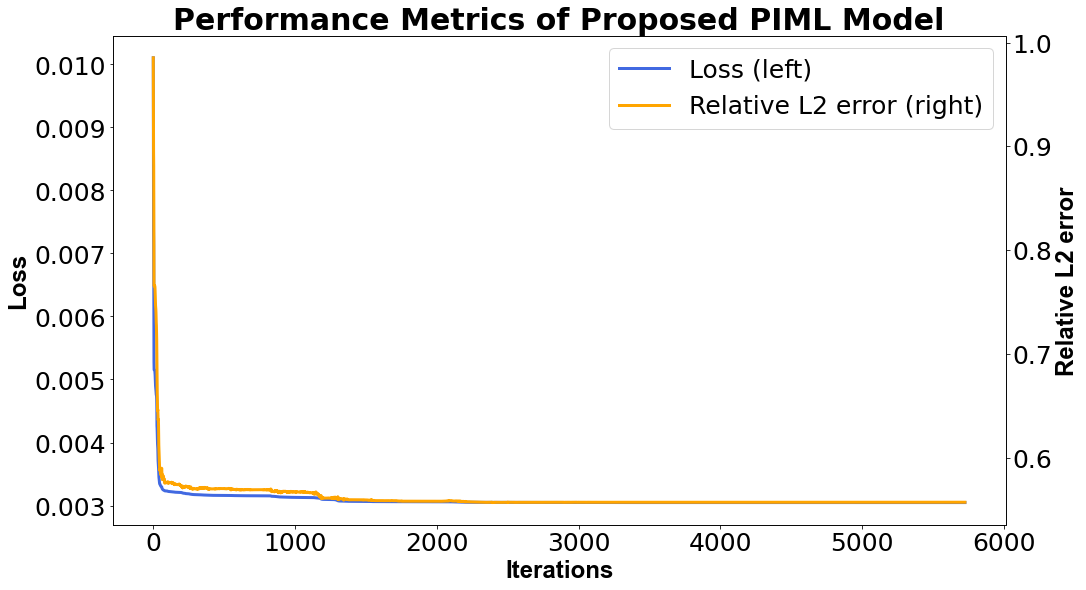

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.02106196822106132
MSE =  0.0028083707577533047
RMSE =  0.05299406341990869
L2 relative error = 0.5038415382498382
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

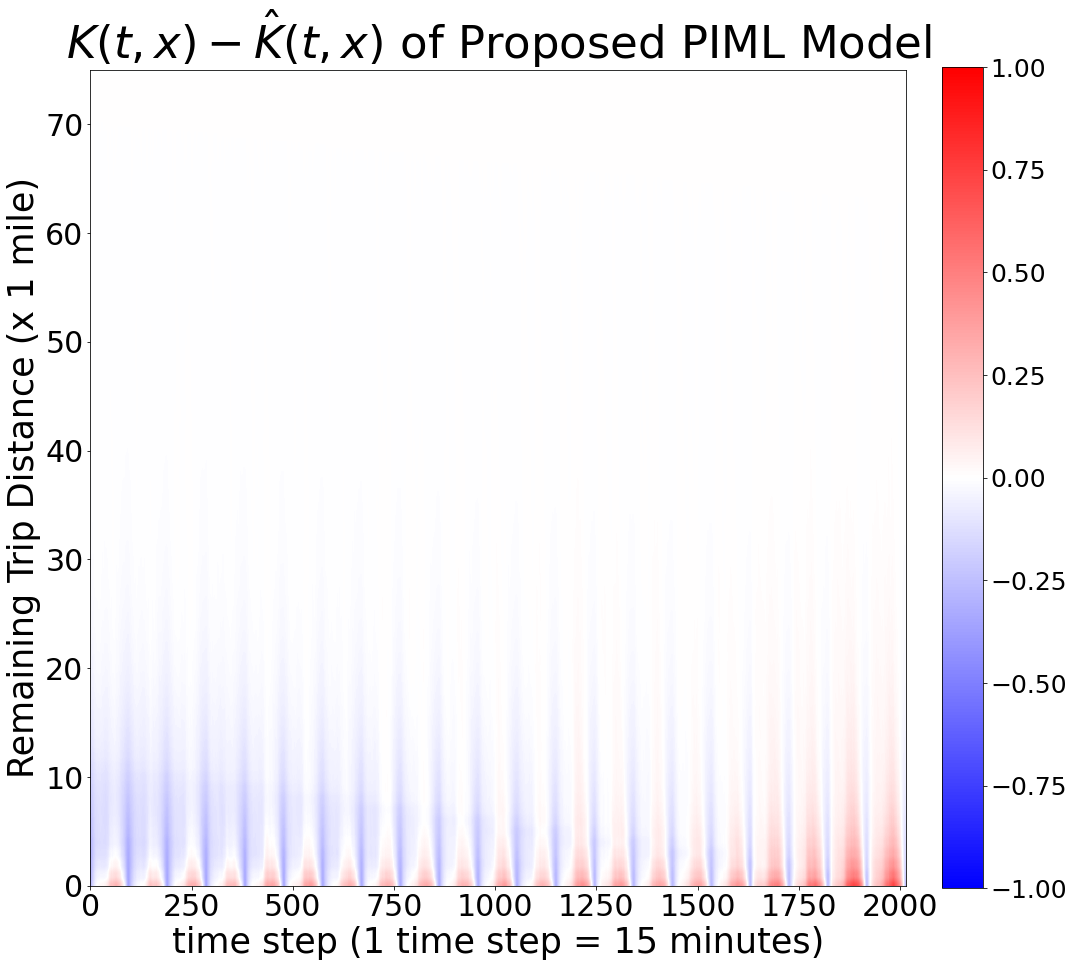

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

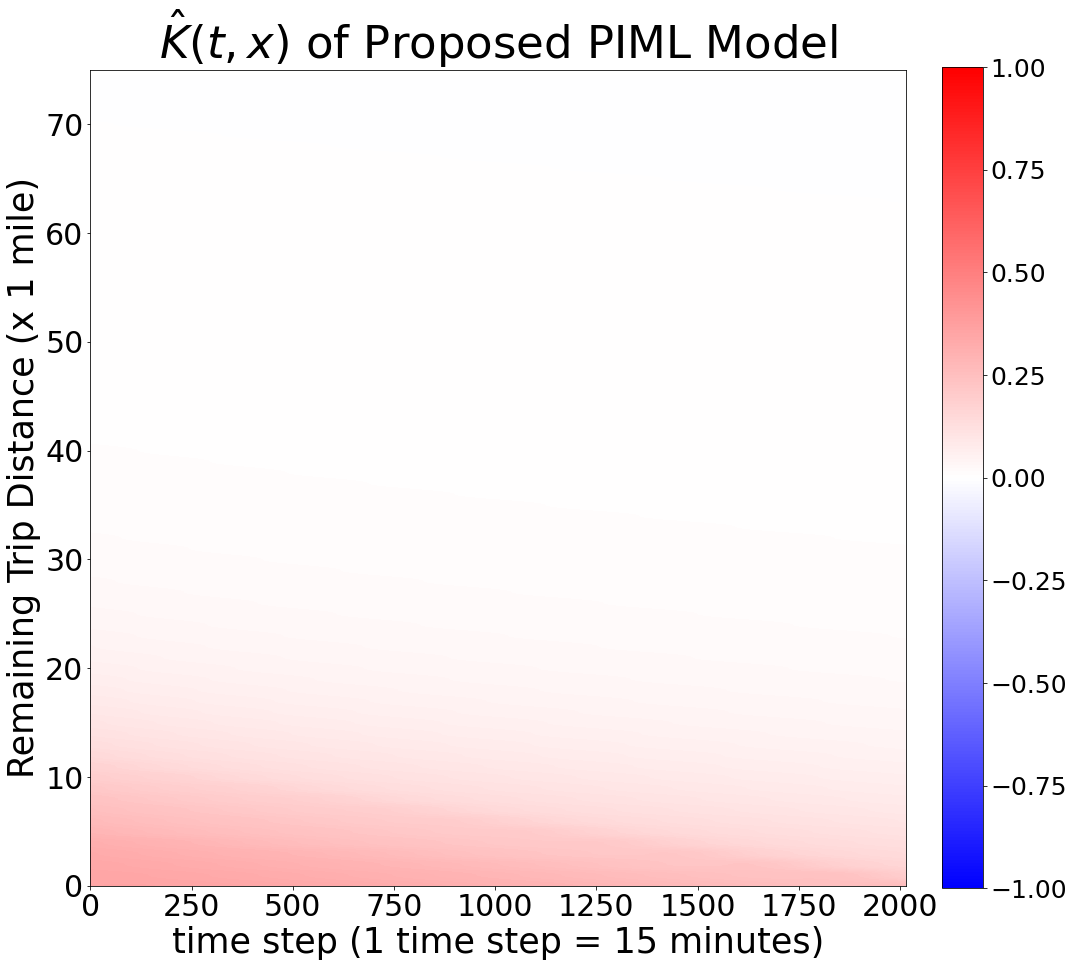

In [20]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

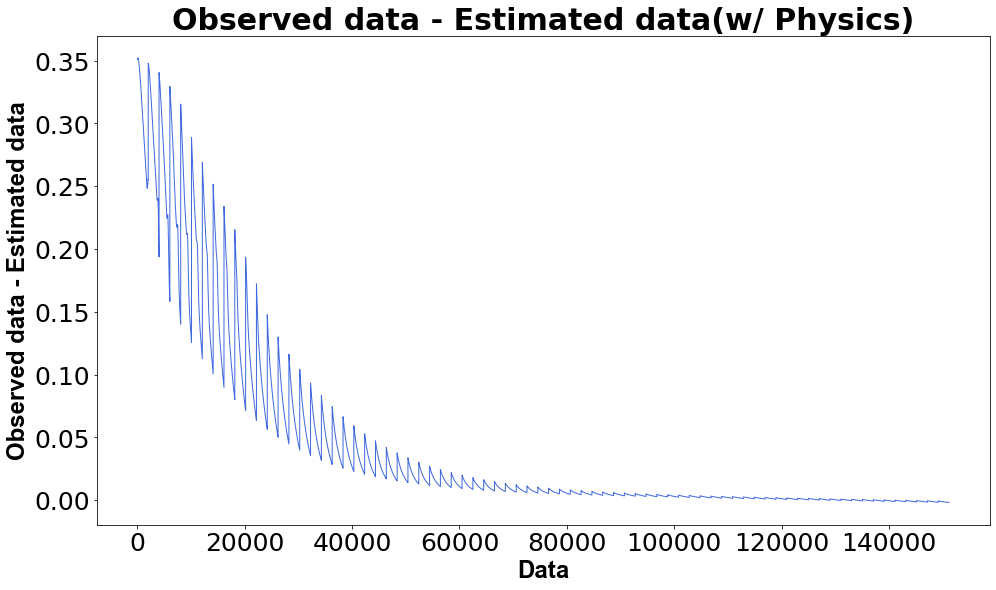

In [21]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

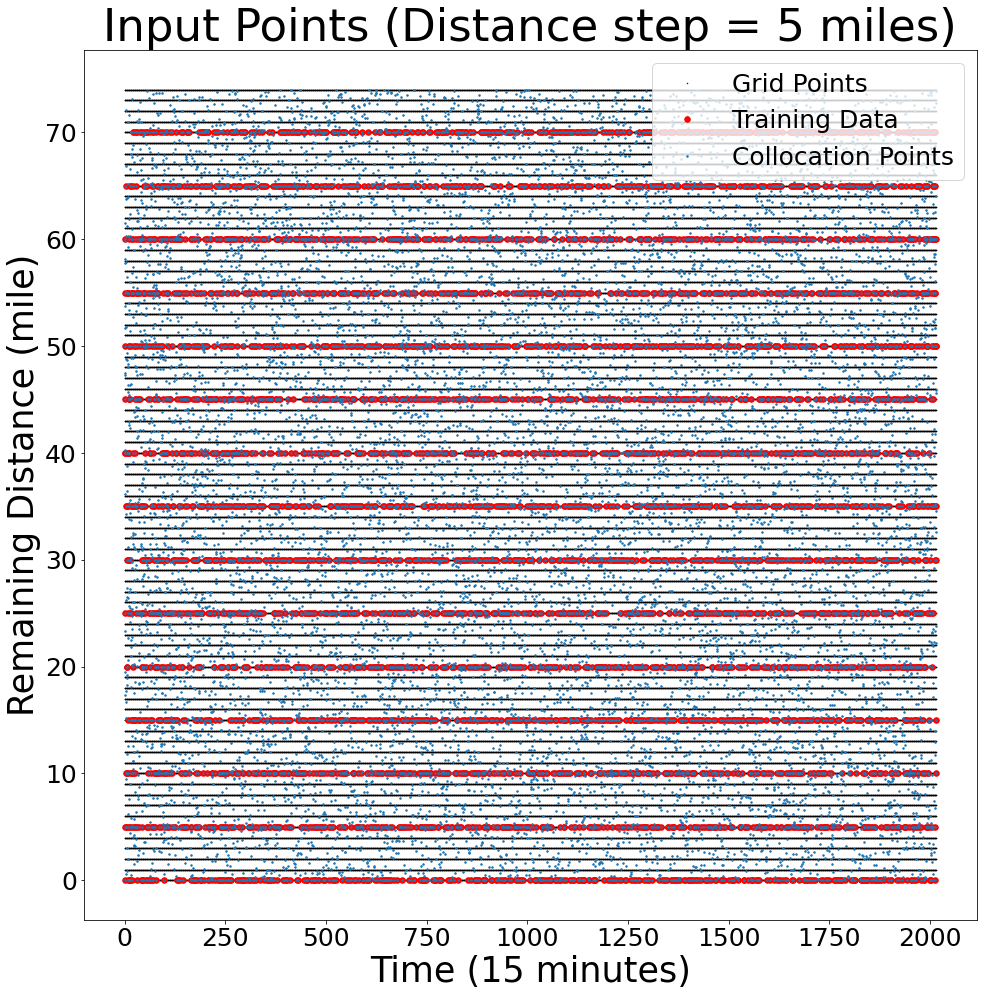

In [22]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()